1. 
First need to read in the weekly returns for the 9 specified stocks from the period Jan 2005 - Dec 2009.
Stocks are Wells Fargo, JP Morgan, Apple, Microsoft, Google, IBM, Walmart, AIG, and GE.

In [28]:
#Need to run this command at anaconda prompt: "$ pip3 install yfinance"
import arch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import median_absolute_deviation as mad
import yfinance as yf


Note: google IPO'd in late 2003, so in order to get the sliding window data from before our 2005 start date, we actually have to drop it from our calculation. So, be aware that the number of assets we are considering is actually only 8. 

In [3]:
#spx is the sp500
data = yf.download(
        tickers = 'wfc jpm aapl msft ibm wmt aig ge spy', 
        start = "2002-09-10", 
        end = "2008-12-31",
        interval = "1wk",
        group_by = 'ticker',
        threads = True)

[*********************100%***********************]  9 of 9 completed


Now lets turn this multi-index df into a regular df and looking only at AdjClose which we'll use to calculate 
the logreturn values weekly. Also, periodic NA values result from yfinance throwing in random non week ending datapoints, probably resulting from choosing Jan 1st 2005 as the starting point which was a Saturday. So, lets drop those and then calculate log returns. $$ \textbf{Beware, running this cell twice kills the structure, so if you do, you need to run the yf.download cell again before moving on.} $$

In [4]:
AdjClose = data.iloc[:, data.columns.get_level_values(1) == 'Adj Close']
processed = AdjClose.dropna()
processed.columns = processed.columns.droplevel(1)  #turns columns from multi-index to normal index
logRet = np.log(processed)
logRet = logRet.diff()
logRet = logRet.dropna()
logRet.head(120)

,AAPL,MSFT,SPY,JPM,WFC,WMT,IBM,GE,AIG
Date,,,,,,,,,
2002-09-16,0.048219,-0.009437,-0.061161,-0.088166,-0.045647,0.005500,-0.125954,-0.011153,-0.039153
2002-09-23,-0.010141,-0.047684,-0.014678,-0.095608,0.032728,-0.063960,-0.057306,-0.089086,-0.020075
2002-09-30,-0.048008,-0.033254,-0.023847,-0.103302,-0.076986,0.009904,-0.064318,-0.012003,-0.046891
2002-10-07,0.033638,0.110215,0.040743,0.055920,0.043404,0.039406,0.121624,0.008295,0.125219
2002-10-14,-0.011786,0.083955,0.051863,0.098530,0.072246,0.044509,0.149805,0.096024,0.064507
...,...,...,...,...,...,...,...,...,...
2004-11-29,-0.029398,0.023408,0.007576,0.009769,-0.001601,-0.044164,0.024610,0.010944,0.026599
2004-12-06,0.038650,-0.005524,0.000671,-0.011362,0.009887,-0.004165,-0.004232,0.023719,-0.006937
2004-12-13,-0.002459,-0.004441,0.000921,0.023376,-0.016318,-0.013177,-0.004874,0.001634,0.000000


2. 
Conduct the NPEB analysis on the individual returns in order to generate the return distribution as well as the covariance relationships.



and via the text, we know that $\mu_{n}$ and $\textbf{V}_{n}$ are 

$$ \mu_{n} = (\hat{\beta}_{1}^{T} x_{1,n-1}, ... , \hat{\beta}_{m}^{T} x_{m,n-1} )^{T} $$

$$ \textbf{V}_{n} = \textbf{\mu}_{n} \textbf{\mu}_{n}^{T} + (\hat{s}_{i,n} \hat{s}_{j,n} \hat{\sigma}_{i,j}) $$

Then, search for $\eta$ by minimizing (2.11) for given $\lambda$, followed by searching for $\lambda$ over a grid to maximizing the information ratio: 
$$E_{\mu, \Sigma} (w_{\lambda}^{T} r - r_{b}) / \sqrt{(Var_{\mu, \Sigma} (w_{\lambda}^{T} r - r_{b})} $$



In [7]:
#Define function for calculating optimal weight portfolio and eta for given lambda
def calcOptPortfolioWeight(mu_n, V_n, risk_lambda, i, logRet, windowSize):
    informationRatio = -1000000 #essentially like -inf
    optWeight = np.ones(mu_n.shape)
    inverseV_n = np.linalg.inv(V_n)
        
    ones = np.ones(mu_n.shape[0])  
    
    
    for lam in risk_lambda:
        

    
        A_n = np.transpose(mu_n)@inverseV_n@ones
        B_n = np.transpose(mu_n)@inverseV_n@mu_n
        C_n = np.transpose(ones)@inverseV_n@ones

        
    
        assert (B_n - (A_n**2)/C_n)*(B_n - ((A_n**2)/C_n) - 1) < 0
    
        Z2 = (B_n - ((A_n**2)/C_n))*(B_n - ((A_n**2)/C_n) - 1)
        Z1 = ((1/(2.0*lam)) + (A_n/C_n))*(B_n - ((A_n**2)/C_n))
        eta = -(Z1*2*lam)/Z2
        
        if eta < 0:
            print("Eta O.O.B")
            continue
            
        term1 = (1.0/C_n)*inverseV_n@ones 
        term2 = (eta/(2*lam))*inverseV_n@(mu_n - (A_n/C_n)*ones)

        weight = term1 + term2
        newInfoRatio = infoRatio(weight, i, logRet, windowSize)
        
        if newInfoRatio > informationRatio:
            informationRatio = newInfoRatio
            optWeight = weight
        
    return optWeight
        
def infoRatio(weight, i, logRet, windowSize):
    leftIndex = max(0, i - windowSize)
    excessReturns = np.ones(windowSize)
    for idx, time in enumerate(range(leftIndex, i)):
        returns =  np.transpose(weight)@logRet.iloc[time, logRet.columns != 'SPY']
        excessReturns[idx] = returns - logRet.iloc[time, logRet.columns == 'SPY']
    expectedMean = np.mean(excessReturns)
    expectedVar = np.var(excessReturns)
    infRatio = (expectedMean / expectedVar)

    return infRatio
        


In [8]:
## Lets first find the prior distribution via MLE estimators (practice of NPEB). 
#First, we can model the return at time t as Linear Regression with Garch errors


X = logRet.shift(1) #we'll be using prevoius observations
risk_lambda = [2**i for i in range(-3,3)]  #We shrink lambda set, otherwise returns get too large
numAssets = 8
NPEBExcessReturn = np.zeros(len(logRet) - windowSize)
NPEBReturn = np.zeros(len(logRet) - windowSize)
windowSize = 120
plotting_df = pd.DataFrame(columns = ["Excess Return"])

s_prev = np.zeros((len(logRet), numAssets))


for i in range(windowSize, len(logRet)): #len(logRet))):
    mu_n = np.zeros(numAssets)
    V_n = np.ones((numAssets, numAssets))
    z_t = pd.DataFrame()
    
    iterator = 0

    for col in logRet.columns:
        if col == 'SPY':
            continue
            
        
        leftIndex = max(0, i - windowSize)
        col_1 = X.columns.get_loc('SPY')
        col_2 = X.columns.get_loc(col)
        exog = X.iloc[leftIndex:i, col_1]
        y = logRet.iloc[leftIndex:i, logRet.columns == col].to_numpy().flatten()
    
        model = arch.arch_model(y, x = exog, mean = 'ARX', lags = [1], dist = 't', rescale = True)
        res = model.fit(disp = 'off')
        scale = res.scale
        data = np.array([1,X.iloc[i, col_1], X.iloc[i, col_2]])

        
        #parmams list as follows: also need to undo rescale for parameters
        Beta_constant = res.params[0]  
        Beta_SPY = res.params[1]       
        Beta_prevReturn = res.params[2]       
        s_omega = res.params[3]   
        s_alpha = res.params[4] 
        s_beta = res.params[5]   
        s_nu = res.params[6]
        
        #Values needed to calculate mu_n
        mu_n[iterator] = np.transpose(np.array([Beta_constant, Beta_SPY, Beta_prevReturn]))@data  / scale
        
        data2 = {'SPY': [X.iloc[i, col_1]]}
        forecast = res.forecast(x = data2, horizon = 1,reindex = False)
        
        
        #Values needed to calculate V_n, prev
        residuals = res.resid
        all_s = res.conditional_volatility
        s_i = forecast.variance['h.1'].iloc[0]**.5
        s_prev[i, iterator] = s_i
        z_t[iterator] = residuals / all_s

        
        iterator += 1
            
    V_n = np.outer(mu_n, mu_n) + np.outer(s_prev[i], s_prev[i]) * (z_t.cov())
    
                                                                     
    optimalWeights = calcOptPortfolioWeight(mu_n, V_n, risk_lambda, i, logRet, windowSize)
    NPEBReturn[i - windowSize] =  np.transpose(optimalWeights)@logRet.iloc[i, logRet.columns  != 'SPY']
    plotting_df.loc[logRet.index[i]] = [NPEBReturn[i-windowSize]]
    NPEBExcessReturn[i - windowSize] = NPEBReturn[i-windowSize] - logRet.iloc[i, logRet.columns == 'SPY']
    
        


Eta O.O.B


In [31]:
#Let's look at the returns, and calculate InformationRatio

TrackingError = (mad(NPEBExcessReturn)**2)
NPEBMeanExcess = np.mean(NPEBExcessReturn)

NPEBMeanReturn = np.mean(NPEBReturn)
NPEBVarReturn = (mad(NPEBReturn)**2)

InformationRatio = (NPEBMeanExcess / mad(NPEBExcessReturn, scale = 1)) * np.sqrt(52)
SharpeRatio = (NPEBMeanReturn / mad(NPEBReturn, scale = 1)) * np.sqrt(52)



normalizedRet = (np.exp(NPEBMeanReturn*52)-1)*100
print("Average annual return: " + str(normalizedRet) +  "%")


print("Variance of our Portfolio: " + str(NPEBVarReturn))
print("Mean Return of our Portfolio: " + str(NPEBMeanReturn))
print("Sharpe ratio of our NPEB Portfolio: " + str(SharpeRatio))

print("\n\n\n")

print("Tracking Error of our Portfolio: "  +  str(TrackingError))
print("Mean Excess Return of our Portfolio: " + str(NPEBMeanReturn))
print("Information ratio of our NPEB Porfolio: " + str(InformationRatio))




Average annual return: 12.839506386090683%
Variance of our Portfolio: 0.0013645487359204812
Mean Return of our Portfolio: 0.0023230062630293907
Sharpe ratio of our NPEB Portfolio: 0.6723285018455577




Tracking Error of our Portfolio: 0.0007425861855283203
Mean Excess Return of our Portfolio: 0.0023230062630293907
Information ratio of our NPEB Porfolio: 1.3137921230862508


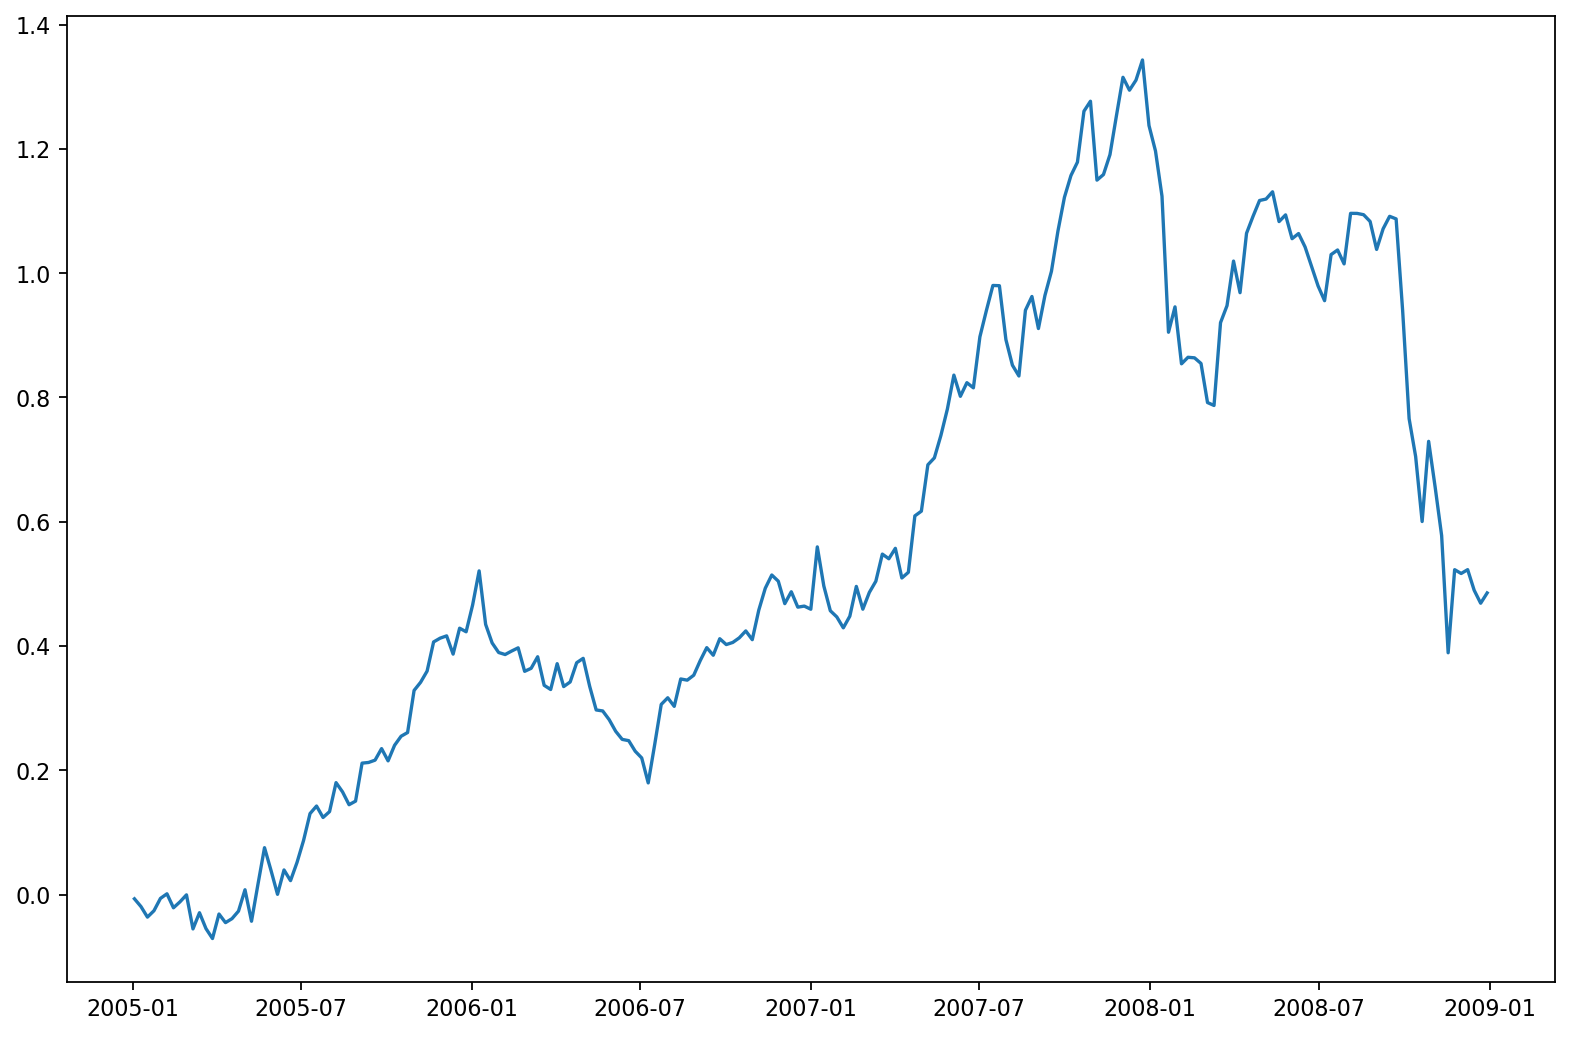

In [32]:
#Define function for calculating mu and V
plt.figure(figsize=(12,8), dpi = 160)
cumulativeReturn = np.cumsum(plotting_df["Excess Return"])
plt.plot(cumulativeReturn)

5. 
Using these dynamic portfolio weights, model the cumulative returns for the period and compare them to plug-in portfolio.

In [33]:
#Lets first find the plug-in returns using the same idea with a sliding window

def optimalWeight(retMean, retCov, targetReturn, riskFree):
    inverseCov = np.linalg.inv(retCov)
    riskAdjMean = np.subtract(retMean, riskFree)
    one = np.ones((len(retMean),1))
    
    A = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@one)
    B = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@riskAdjMean)
    C = np.transpose(one)@inverseCov@one
    D = B*C - A**2

    numerator = B*inverseCov@one - A*inverseCov@riskAdjMean
    numerator += targetReturn*(C*inverseCov@riskAdjMean - A*inverseCov@one)
    optimalWeights = numerator * (1/D)

    return optimalWeights

In [42]:
windowSize = 120
rf = 0
muStar = 0.15

#In order to find the plug-in portfolio that returns the highest information ratio, we'll need to do some
#grid searching

mu_vals = [muStar]

plugInReturn = np.zeros(len(logRet) - windowSize)
returns = np.zeros(len(logRet) - windowSize)
riskFree = np.full((numAssets,1), rf)
plug_in_plotting_df = pd.DataFrame(columns = ["Excess Return"])


for i in range(windowSize, len(logRet)):   #algo unstable for low history, so we start at n = 10
    leftIndex = max(0, i - windowSize)
    sampleMean = logRet.iloc[leftIndex:i, logRet.columns != 'SPY'].mean(axis = 0)
    sampleCov = logRet.iloc[leftIndex:i, logRet.columns != 'SPY'].cov()
    periodRet = logRet.iloc[i, logRet.columns != 'SPY']
    marketRet = logRet.iloc[i, logRet.columns == 'SPY']
        
    sampleMeanMatrix = sampleMean.to_numpy()
    sampleMeanMatrix = sampleMeanMatrix.reshape((numAssets,1))
    sampleCovMatrix = sampleCov.to_numpy()
    periodRetMatrix = periodRet.to_numpy()
    
    infoMax = -1000000
    optimalweights = np.zeros(numAssets)
    
    
    for mu in mu_vals:
        optimalweights = optimalWeight(sampleMeanMatrix, sampleCovMatrix, mu, riskFree)
        expectedReturn = np.ndarray.item(np.transpose(optimalweights)@sampleMeanMatrix)
        expectedVariance = np.ndarray.item(np.transpose(optimalweights)@sampleCovMatrix@optimalweights)
        temp = (expectedReturn - marketRet.values[0]) / np.sqrt(expectedVariance)
        if temp > infoMax:
            maxWeight = optimalweights
            infoMax = temp
            
    returns[i - windowSize] = np.transpose(maxWeight)@periodRetMatrix 
    excessReturns = returns[i-windowSize] - marketRet.values[0]
    plugInReturn[i - windowSize] = excessReturns
    plug_in_plotting_df.loc[logRet.index[i]] = excessReturns

#Scale for variance of returns
variance = (mad(returns)**2)
plugInReturn = plugInReturn * (NPEBVarReturn / variance)
plug_in_plotting_df["Excess Return"]  = plug_in_plotting_df["Excess Return"].apply(lambda x: x*(NPEBVarReturn / variance))


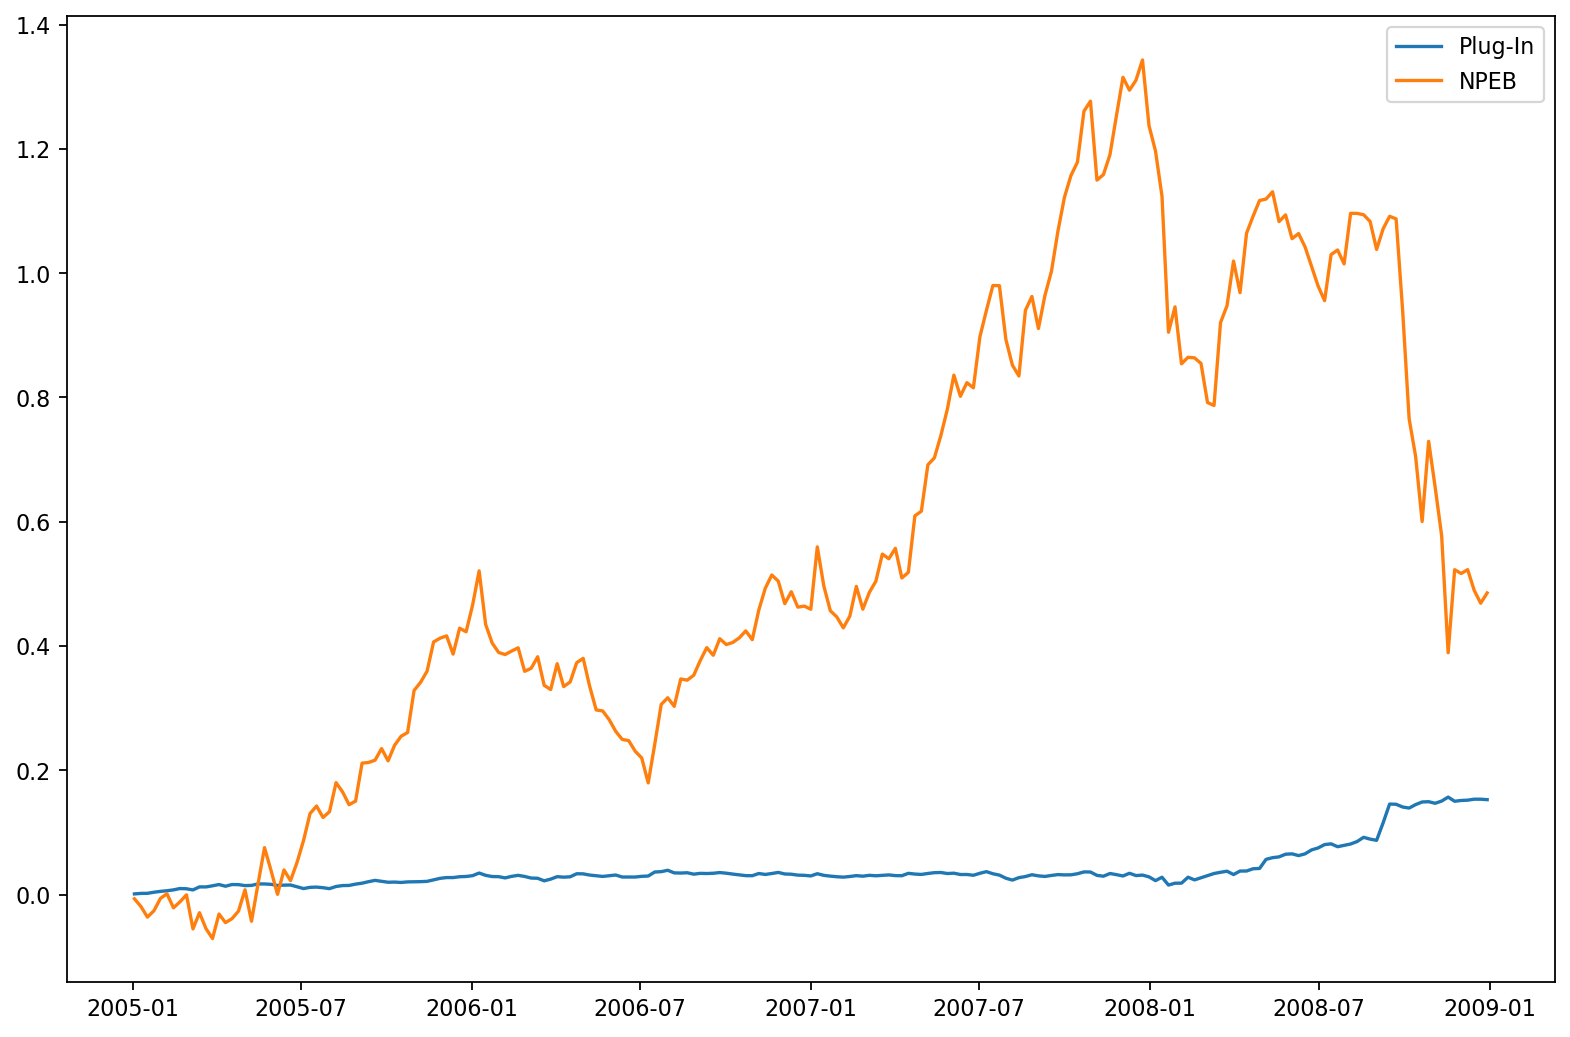

In [43]:
plt.figure(figsize=(12,8), dpi = 160)


plugIn = np.cumsum(plug_in_plotting_df["Excess Return"])

plt.plot(plugIn, label = "Plug-In")
plt.plot(cumulativeReturn, label = "NPEB")
plt.legend()
